In [3]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

from datetime import datetime
from qutip.qobj import Qobj
from collections.abc import Iterable
from typing import Callable, List, Optional, Tuple
from datetime import datetime
from scipy.integrate import odeint

In [4]:
import sys 
path = 'C:/Users/Tomas/PhD_Physics/3rd_Year/Max-Ent_Library'
sys.path.insert(1, path) 

import a_quantum_geometries as gij
import b_spin_ops as su2
import c_maxent_tools as me

In [22]:
params={}

params['size']=5
params['beta']=5.

params['omega']=.5*np.pi*1.; 

params['Jx'] =5*10**-1*params['omega']; params['Jy'] = .5*params['Jx']; params['chain_type']='XY'

params['Omega']=.9999*params['omega']; params['V0']=2.4*.05;params['phase'] = np.pi/4; params['period']=2.*np.pi/params['Omega']

print(params['V0']/params['Omega'])

0.0764020128853983


In [23]:
spin_ops=su2.one_body_spin_ops(args=params)

idop=spin_ops['idop']
sx_total=sum(sx for sx in spin_ops['sx'])
sy_total=sum(sx for sx in spin_ops['sy'])
sz_total=sum(sx for sx in spin_ops['sz'])

In [24]:
H0=params['omega']*sz_total
Hint=1.*su2.Heisenberg_1D_Hamiltonian(spin_ops=spin_ops, args=params)

### Lab
driving_td=lambda t,args: args['V0']*np.cos(args['Omega']*t+args['phase'])
Hlab=[H0+Hint,[sx_total, driving_td]]

### RWA
Hrwa=H0-params['Omega']*sz_total 
Hrwa+=Hint 
Hrwa+=params['V0']*.5*(np.cos(params['phase'])*sx_total + np.sin(params['phase'])*sy_total)

### ROT (RWA+CR)
rot_sx_tdterm=lambda t,args: .5*args['V0']*np.cos(2*args['Omega']*t+args['phase'])
rot_sy_tdterm=lambda t,args: -.5*args['V0']*np.sin(2*args['Omega']*t+args['phase'])

Hrot_func=lambda t,args: Hrwa+rot_sx_tdterm(t=t,args=args)*sx_total+rot_sy_tdterm(t=t,args=args)*sy_total
Hrot=[Hrwa,[sx_total, rot_sx_tdterm],[sy_total, rot_sy_tdterm]]

In [25]:
HBB0=[idop, sx_total, sy_total, Hint, sz_total]
phi0=np.array([0., 1, 0, -1, 5.2])
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
phi0[0]=np.log(sigma0.tr())
K0 = -sum(phia * opa for phia,opa in zip(phi0, HBB0))
sigma0=gij.safe_expm_and_normalize(K=K0)
HBB0+=[K0]

qutip.expect(spin_ops['sz'], sigma0)

array([-0.48262814, -0.48262814, -0.48262814, -0.48262814, -0.48262814])

In [26]:
N=400
T=2*np.pi/max(.001,abs(params['V0']))/N
timespan = np.linspace(0,N*T,N)

resex=qutip.mesolve(H=Hlab,
                    rho0=K0,
                    tlist=timespan,
                    args=params)

resrwa=qutip.mesolve(H=Hrwa,
                     rho0=K0,
                     tlist=timespan,
                     args=params)

resrot=qutip.mesolve(H=Hrot,
                       rho0=K0,
                       tlist=timespan, 
                       args=params) 

Urot = lambda t,args: (-1j*sz_total*args['Omega']*t).expm()
Urot_td=[Urot(t=ti,args=params) for ti in timespan]
exact_Ks_labframe=[Urot_ti.dag() * Kti * Urot_ti for Urot_ti,Kti in zip(Urot_td,resex.states)]

rhos_resrwa=[gij.safe_expm_and_normalize(K=Kt) for Kt in resrwa.states]
rhos_resex=[gij.safe_expm_and_normalize(K=Kti) for Kti in exact_Ks_labframe]
rhos_rotcr=[gij.safe_expm_and_normalize(K=Kti) for Kti in resrot.states]

In [27]:
ds=[2,6]
sigmas_maxent_tI, Ks_maxent_tI=me.multiple_projections(
                             exact_Ks=resrwa.states, exact_states=rhos_resrwa,
                             generator=Hrwa, K0=K0,
                             basis0=HBB0, depths=ds,
                             timespan=timespan, args=params, td_generator=False, magnus=False)

**** Starting Simulation 2024-04-13 22:20:03.237958
   -----Processing step 0 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 80 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 160 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 240 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 320 at time <built-in method now of type object at 0x00007FF8C3B0C500>
**** Starting Simulation 2024-04-13 22:20:12.554825
   -----Processing step 0 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 80 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 160 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 240 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 320 at time <built-in m

In [28]:
# ds=[0, 3]

sigmas_maxent_tD_nonmagnus, Ks_maxent_tD_nonmagnus=me.multiple_projections(
                             exact_Ks=resrwa.states, exact_states=rhos_resrwa,
                             generator=Hrot_func, K0=K0,
                             basis0=HBB0, depths=ds,
                             timespan=timespan, args=params, td_generator=True, magnus=False)

sigmas_maxent_tD, Ks_maxent_tD=me.multiple_projections(
                             exact_Ks=resrwa.states, exact_states=rhos_resrwa,
                             generator=Hrot_func, K0=K0,
                             basis0=HBB0, depths=ds,
                             timespan=timespan, args=params, td_generator=True, magnus=True)

**** Starting Simulation 2024-04-13 22:20:47.143596
   -----Processing step 0 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 80 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 160 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 240 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 320 at time <built-in method now of type object at 0x00007FF8C3B0C500>
**** Starting Simulation 2024-04-13 22:20:56.474067
   -----Processing step 0 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 80 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 160 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 240 at time <built-in method now of type object at 0x00007FF8C3B0C500>
   -----Processing step 320 at time <built-in m

C:\Users\tomas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\tomas\anaconda3\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


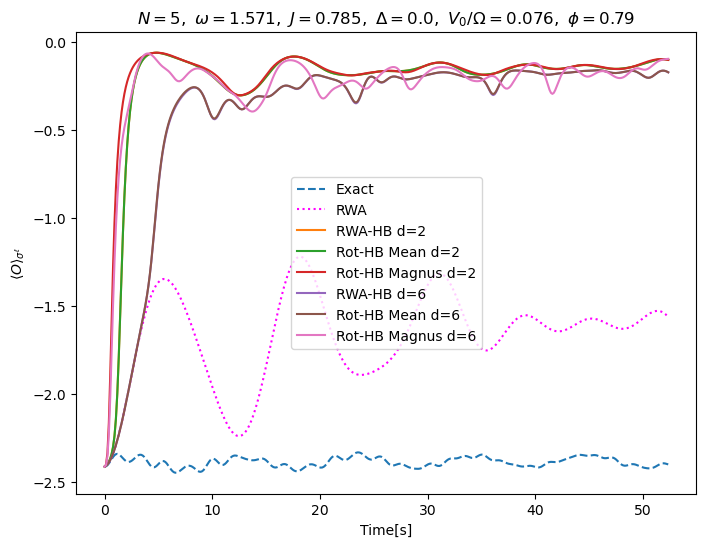

In [29]:
obs1=spin_ops['sy'][2]*spin_ops['sy'][3]
obs=sz_total

obs_evex=np.array([(rho*obs).tr() for rho in rhos_resex])
obs_evrwa=np.array([(sigma*obs).tr() for sigma in rhos_resrwa])
obs_evrot=np.array([(sigma*obs).tr() for sigma in rhos_rotcr])

obs_maxent_TD=[np.array([(sigma_ell*obs).tr() for sigma_ell in sigmas_maxent_ell1]) 
                                                 for sigmas_maxent_ell1 in sigmas_maxent_tD]
obs_maxent_TD_nonmagnus=[np.array([(sigma_ell*obs).tr() for sigma_ell in sigmas_maxent_ell1]) 
                                                 for sigmas_maxent_ell1 in sigmas_maxent_tD_nonmagnus]
obs_maxent_TI=[np.array([(sigma_ell*obs).tr() for sigma_ell in sigmas_maxent_ell1]) 
                                                  for sigmas_maxent_ell1 in sigmas_maxent_tI]

fig0,ax0=plt.subplots(figsize=(8,6))

plt.plot(timespan, obs_evex, label='Exact', linestyle='dashed')
plt.plot(timespan, obs_evrwa, label='RWA', linestyle='dotted', color='magenta')
#plt.plot(timespan, obs_evrot, label='Rot (CR)', linestyle='dashdot', color='black')
for d in ds: 
    plt.plot(timespan, obs_maxent_TI[ds.index(d)], label='RWA-HB d='+str(d))
    plt.plot(timespan, obs_maxent_TD_nonmagnus[ds.index(d)], label='Rot-HB Mean d='+str(d))
    plt.plot(timespan, obs_maxent_TD[ds.index(d)], label='Rot-HB Magnus d='+str(d))
ax0.legend(loc=0)
plt.xlabel("Time[s]")
plt.ylabel(r"$\langle O \rangle_{\sigma^\ell}$")
plt.title(r'$N={},\,\,\omega={},\,\, J={},\,\, \Delta={},\,\, V_0/\Omega={}, \,\, \phi={}$'.format(
                                                                params['size'],
                                                                round(params['omega'],3), 
                                                                round((params['Jx']),3), 
                                                                round(params['omega']-params['Omega'],3), 
                                                                round(params['V0']/params['Omega'],3),
                                                                round(params['phase'],2)))
plt.show()

In [40]:
linalg.norm(Hrot_func(t=params['period']/2, args=params))*params['period']

1.239427294160536

In [45]:
def magnus_1t(generator, args):
    period=args.get('period')
    local_timespan_period=np.linspace(0,period, int(period)*100)
    local_magnus=0
    for t1 in local_timespan_period:
        for t2 in local_timespan_period:
            if t2 <= t1:
                local_magnus+=gij.commutator(generator(t=t1, args=args), generator(t=t2, args=args))

    return 1/(2*1j*period)*local_magnus*(local_timespan_period[1]-local_timespan_period[0])

h1t=magnus_1t(generator=Hrot_func, args=params)

In [58]:
period=params.get('period')
local_timespan_period=np.linspace(0,period,int(period)*100)
converg_criterion=sum(linalg.norm(Hrot_func(t=ti,args=params)) for ti in local_timespan_period)

magnus_1_list=[[gij.commutator(Hrot_func(t=ti1,args=params), Hrot_func(t=ti2,args=params))
                for ti2 in local_timespan_period] for ti1 in local_timespan_period]

magnus_1=sum(sum(Ht[ti1][ti2]))

In [59]:
def calculate_first_magnus_term(generator,period):
    """
    Calculate the first term in the Magnus expansion.

    Args:
        H (function): Hamiltonian function that returns the Hamiltonian
                      at time t.
        tlist (array_like): List of time points.

    Returns:
        ndarray: The first term in the Magnus expansion.
    """
    local_timespan=np.linspace(0,period,
    first_magnus_term = np.zeros_like(H(tlist[0]))

    for i in range(n):
        for j in range(i):
            dt1 = tlist[i] - tlist[j]
            dt2 = tlist[j]

            commutator = np.dot(H(tlist[i]), H(tlist[j])) - np.dot(H(tlist[j]), H(tlist[i]))

            first_magnus_term += commutator * dt1 * dt2 / 2

    return expm(first_magnus_term)

AttributeError: module 'qutip' has no attribute 'magnus'

In [64]:
from scipy.integrate import dblquad
def integrand(t1,t2):
    return gij.commutator(Hrot_func(t=t1, args=params), Hrot_func(t=t1,args=params))

result, _ = dblquad(integrand, 0, period, lambda t1: 0, lambda t1: t1)


TypeError: must be real number, not Qobj